In [1]:
import torch.optim as optim
import torchvision.datasets as dset 
from torchvision.transforms import transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

In [2]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/cnn")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class NoiseClassifier(nn.Module):
    def __init__(self):
        super(NoiseClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
train_dataset = dset.ImageFolder(root='mel-spectrogram/train',
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

test_dataset = dset.ImageFolder(root='mel-spectrogram/test',
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [6]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

batch = next(iter(train_dataloader))

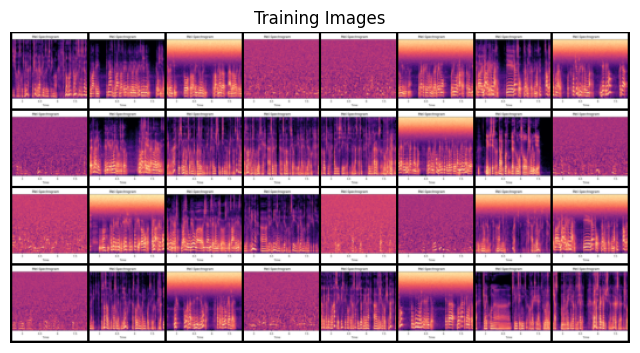

In [7]:
batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to('cpu')[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
learning_rate = 0.0005
model = NoiseClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10
model.to(device)

NoiseClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

In [9]:
config = {
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": num_epochs,
    "n_count cnn blocks": 3,
    "architecture": "CNN",
    "device": device,
}
config_text = "\n".join([f"{key}: {value}" for key, value in config.items()])
writer.add_text("Experiment Configuration", config_text)

In [10]:
index = 0
running_loss_train = 0.0
running_loss_test = 0.0
for epoch in trange(num_epochs, desc='Train model'):
    model.train()
    train_loss_epochs = 0.0
    test_loss_epochs = 0.0
    accuracy_train = 0.0
    accuracy_test = 0.0
    for x, labels in train_dataloader:
        index += 1
        x, labels = x.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, labels)
        train_loss_epochs += loss.item()
        running_loss_train += loss.item() / batch_size
        accuracy_train += (torch.max(outputs, axis=1).indices == labels).sum() / len(labels)
        loss.backward()
        optimizer.step()
        if index % 10 == 0 and index != 0:
            writer.add_scalar(
                "Train loss for step", running_loss_train / 10, epoch * len(train_dataloader) + index
            )
            running_loss_train = 0.0

    train_loss_epochs /= len(train_dataloader)
    accuracy_train /= len(train_dataloader)
    print(f"Epoch {epoch}: Train Loss: {train_loss_epochs}")
    print(f"Epoch {epoch}: Train accuracy: {accuracy_train}")

    writer.add_scalar(
        "training loss for epoch", train_loss_epochs, epoch
    )
    writer.add_scalar(
        "Train accuracy for epoch", accuracy_train, epoch
    )
    if epoch % 1 == 0:
        index = 0
        with torch.no_grad():
            model.eval()
            for x_test, labels_test in test_dataloader:
                x_test, labels_test = x_test.to(device), labels_test.to(device)
                index += 1
                outputs_test = model(x_test)
                loss_test = criterion(outputs_test, labels_test)
                test_loss_epochs += loss_test.item()
                running_loss_test += loss_test.item() / batch_size
                accuracy_test += (torch.max(outputs, axis=1).indices == labels).sum() / len(labels)
                if index % 5 == 0 and index != 0:
                    writer.add_scalar(
                        "Test loss for step", running_loss_test / 5, epoch * len(test_dataloader) + index
                    )
                    running_loss_test = 0.0
            test_loss_epochs /= len(test_dataloader)
            accuracy_test /= len(test_dataloader)
            print(f"Epoch {epoch}: Test Loss: {test_loss_epochs}")
            print(f"Epoch {epoch}: Test Accuracy: {accuracy_test}")
            writer.add_scalar("Test loss for epoch", test_loss_epochs, epoch)
            writer.add_scalar("Test accuracy", accuracy_test, epoch) 

Train model:   0%|                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Epoch 0: Train Loss: 0.11309951232555351
Epoch 0: Train accuracy: 0.9748474955558777


Train model:  10%|████████████▍                                                                                                               | 1/10 [00:17<02:34, 17.12s/it]

Epoch 0: Test Loss: 0.002675624052894169
Epoch 0: Test Accuracy: 1.0
Epoch 1: Train Loss: 0.0026676835783602166
Epoch 1: Train accuracy: 0.9992377758026123


Train model:  20%|████████████████████████▊                                                                                                   | 2/10 [00:32<02:10, 16.35s/it]

Epoch 1: Test Loss: 0.0006807104891777271
Epoch 1: Test Accuracy: 1.0
Epoch 2: Train Loss: 0.00015834084092048437
Epoch 2: Train accuracy: 0.9999999403953552


Train model:  30%|█████████████████████████████████████▏                                                                                      | 3/10 [00:48<01:52, 16.12s/it]

Epoch 2: Test Loss: 0.0004186864914247833
Epoch 2: Test Accuracy: 1.0
Epoch 3: Train Loss: 8.407841394772532e-05
Epoch 3: Train accuracy: 0.9999999403953552


Train model:  40%|█████████████████████████████████████████████████▌                                                                          | 4/10 [01:04<01:35, 15.96s/it]

Epoch 3: Test Loss: 0.00020878074038981658
Epoch 3: Test Accuracy: 1.0
Epoch 4: Train Loss: 5.0284787359886675e-05
Epoch 4: Train accuracy: 0.9999999403953552


Train model:  50%|██████████████████████████████████████████████████████████████                                                              | 5/10 [01:20<01:19, 15.90s/it]

Epoch 4: Test Loss: 0.00017584869874553988
Epoch 4: Test Accuracy: 1.0
Epoch 5: Train Loss: 3.43684377318224e-05
Epoch 5: Train accuracy: 0.9999999403953552


Train model:  60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 6/10 [01:36<01:03, 15.86s/it]

Epoch 5: Test Loss: 0.00014143220797840122
Epoch 5: Test Accuracy: 1.0
Epoch 6: Train Loss: 2.4933718746956957e-05
Epoch 6: Train accuracy: 0.9999999403953552


Train model:  70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 7/10 [01:51<00:47, 15.84s/it]

Epoch 6: Test Loss: 0.00011004765118676525
Epoch 6: Test Accuracy: 1.0
Epoch 7: Train Loss: 1.9483181677337487e-05
Epoch 7: Train accuracy: 0.9999999403953552


Train model:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8/10 [02:07<00:31, 15.84s/it]

Epoch 7: Test Loss: 9.153534844179896e-05
Epoch 7: Test Accuracy: 1.0
Epoch 8: Train Loss: 1.554317061729263e-05
Epoch 8: Train accuracy: 0.9999999403953552


Train model:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9/10 [02:23<00:15, 15.81s/it]

Epoch 8: Test Loss: 7.38417808504112e-05
Epoch 8: Test Accuracy: 1.0
Epoch 9: Train Loss: 1.233072400903372e-05
Epoch 9: Train accuracy: 0.9999999403953552


Train model: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:39<00:00, 15.92s/it]

Epoch 9: Test Loss: 6.792449452015197e-05
Epoch 9: Test Accuracy: 1.0
